# Etape 2 : Préparation des données pour notre algorithme de machine learning et Modélisation

In [470]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PolynomialFeatures,RobustScaler,LabelEncoder
from math import sqrt
from sklearn.compose import make_column_selector,make_column_transformer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import pickle5 as pickle
from sklearn.model_selection import learning_curve
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete
from sklearn .model_selection  import cross_validate
import statsmodels.api as sm


In [471]:
df = pd.read_csv('cleaned2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   object 
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 73.2+ KB


## I) Préparation du modèle pour le Machine Learning

#### Introduction : Dans l'étape 1, on a séparer nos variables en deux catégories : quantitatives et catégorielles. Après avoir catégoriser ses variables,on va les transformer  pour qu'elles soient ajuster à notre modèle. 

#### One-Hot-Encoding  :  Pour transformer nos variables catégorielles on va utilise le one-hot encoding , on va convertir les valeurs associées à nos variables en de nouvelles colonnes de variables et on leur assigne une valeur binaire 1 pour présent et 0 pour non existant.

In [472]:
categorical_features = ['sex','smoker','region','bmi']

In [473]:
df[categorical_features] = df[categorical_features].astype('string')

#### Scaling : Pour les variables quantitatives, on utilise des méthodes de scaling telle que la normalisation,standardization lorsqu'une des variables aura un poids plus élevé sur les autres.

In [474]:
numerical_features = ['age','children']

### 1. La magie des Pipelines

#### Une pipeline est une chaine de transformation ,elle va nous permettre de faire plusieurs action de transformation sur nos données.On a au préalables séparer nos variables en deux catégories les valeurs numériques et catégoriques, on va ainsi pouvoir créer deux pipelines. Ici notre target est les charges de l'assurance en fonction des autres paramètres.

In [475]:

preprocessor = ColumnTransformer([
    ("one_hot", OneHotEncoder(handle_unknown='ignore'),categorical_features),
    ("scaling", RobustScaler(), numerical_features),
    
]
)


## II) Modélisation

#### Après avoir créer notre premier transformeur composé des deux pipelines (OneHotEncoding,Standardisation), nous allons maintenant nous attaqué aux différents types de régression linéaire pour ajuster notre modèle.

In [476]:
X = df.drop(['charges'], axis=1)
y = df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.85, random_state=42,stratify=X[['smoker','bmi']])

In [477]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()
X_train.head()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.0042411612549730915

## 1) Les algorithmes de Régression

### A) La Régression Linéaire

In [478]:
lr_pipeline = make_pipeline(preprocessor,PolynomialFeatures(),LinearRegression())
lr_pipeline.fit(X_train,y_train)
lr_pipeline.score(X_train,y_train)


0.8750028205828888

In [479]:
lr_cross = cross_validate(lr_pipeline,X_train,y_train,cv=5,scoring=('r2', 'neg_root_mean_squared_error'),return_train_score=True)
print(lr_cross['test_r2'].mean())
print(lr_cross['test_neg_root_mean_squared_error'].mean())

0.8596412934198469
-4486.069408713039


In [480]:
lr_cross['test_r2']

array([0.88391007, 0.84076386, 0.87655104, 0.82589938, 0.87108212])

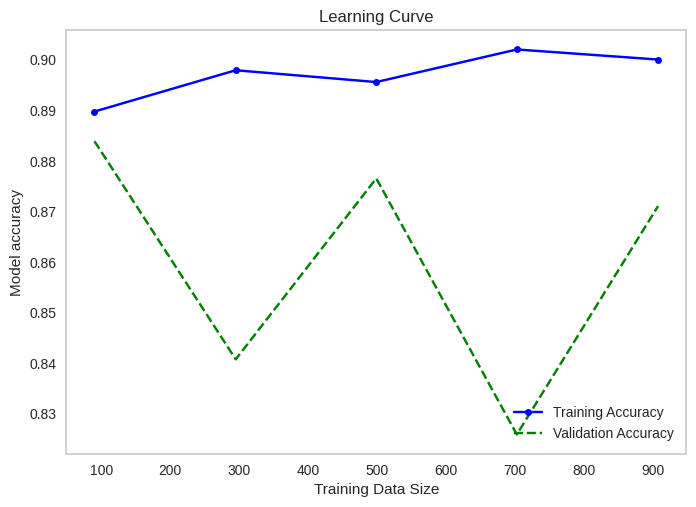

In [481]:
train_sizes, train_scores, test_scores = learning_curve(estimator=lr_pipeline, X=X_train, y=y_train)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=0)
test_mean = lr_cross['test_r2']
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.plot(train_sizes,test_mean , color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()


### B) Elastic Regression

In [482]:
eN_pipeline= make_pipeline(preprocessor,PolynomialFeatures(),ElasticNet(random_state=42))
eN_pipeline.fit(X_train,y_train)
eN_pipeline.score(X_train,y_train)

0.7041247111442472

In [483]:
eN_cross= cross_validate(eN_pipeline,X_train,y_train,cv=5,scoring=('r2', 'neg_root_mean_squared_error'),return_train_score=True)


In [484]:
print(eN_cross['test_r2'].mean())
print(eN_cross['test_neg_root_mean_squared_error'].mean())

0.691455430398532
-6692.575824244906


In [485]:
y_predi = eN_pipeline.predict(X_train)

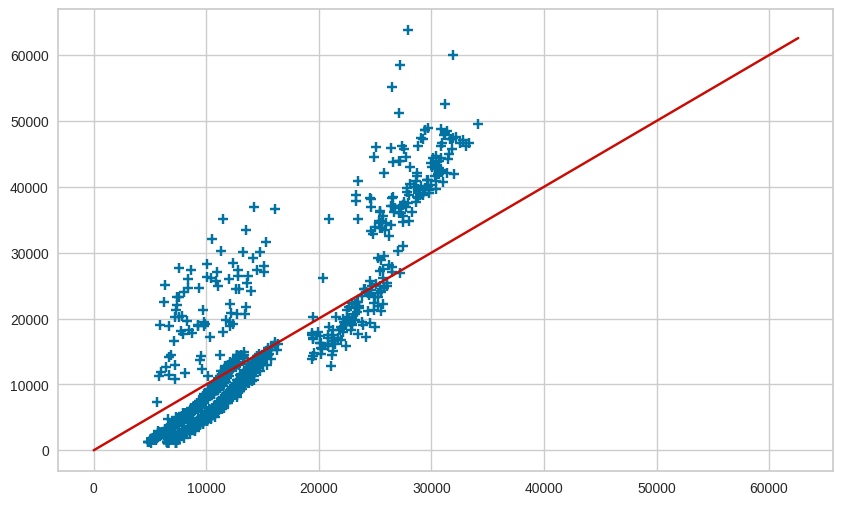

In [486]:
plt.subplots(figsize=(10, 6))
plt.scatter(y_predi,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()

##### A la recherches des meilleurs paramètres

In [506]:

elastic_params = {"elasticnet__alpha" : np.linspace(0,100,500),'elasticnet__l1_ratio': [1],'polynomialfeatures__degree': [2]}
random_elastic = RandomizedSearchCV(eN_pipeline,elastic_params,cv=5,n_iter=100)
random_elastic.fit(X_train,y_train)


/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.535e+08, tolerance: 1.094e+07
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.443e+08, tolerance: 1.188e+07
  model = cd_fast.enet_coordinate_descent(
/home/apprenant/miniconda3/envs/jng/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('one_hot',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['sex',
                                                                                'smoker',
                                                                                'region',
                                                                                'bmi']),
                                                                              ('scaling',
                                                                               RobustScaler(),
                                                                               ['age',
                                                                                'children'])])),
                                             ('polynomialfeatures',
                                              PolynomialFeatures()),
                                             ('elasticnet',
                                              ElasticNet(random_state=42))]),
                   n_iter=100,
                   param_distribut...
        94.58917836,  94.78957916,  94.98997996,  95.19038076,
        95.39078156,  95.59118236,  95.79158317,  95.99198397,
        96.19238477,  96.39278557,  96.59318637,  96.79358717,
        96.99398798,  97.19438878,  97.39478958,  97.59519038,
        97.79559118,  97.99599198,  98.19639279,  98.39679359,
        98.59719439,  98.79759519,  98.99799599,  99.19839679,
        99.3987976 ,  99.5991984 ,  99.7995992 , 100.        ]),
                                        'elasticnet__l1_ratio': [1],
                                        'polynomialfeatures__degree': [2]})

In [507]:
random_elastic.best_params_

{'polynomialfeatures__degree': 2,
 'elasticnet__l1_ratio': 1,
 'elasticnet__alpha': 15.230460921843688}

In [508]:
alpha_elastic = {'elasticnet__alpha': np.linspace(22,25,100)}
eN_model = GridSearchCV(estimator = random_elastic.best_estimator_,cv=5,scoring="r2",param_grid=alpha_elastic)


In [509]:
eN_model.fit(X_train,y_train)
eN_model.score(X_train,y_train)

0.9325673852197371

In [510]:
eN_model.best_params_

{'elasticnet__alpha': 22.0}

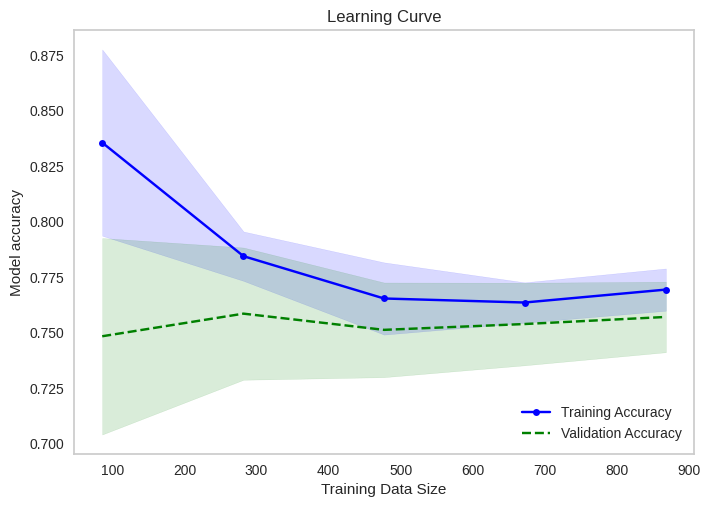

In [511]:
train_sizes, train_scores, test_scores = learning_curve(estimator=eN_pipeline, X=X_train, y=y_train,verbose=False)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

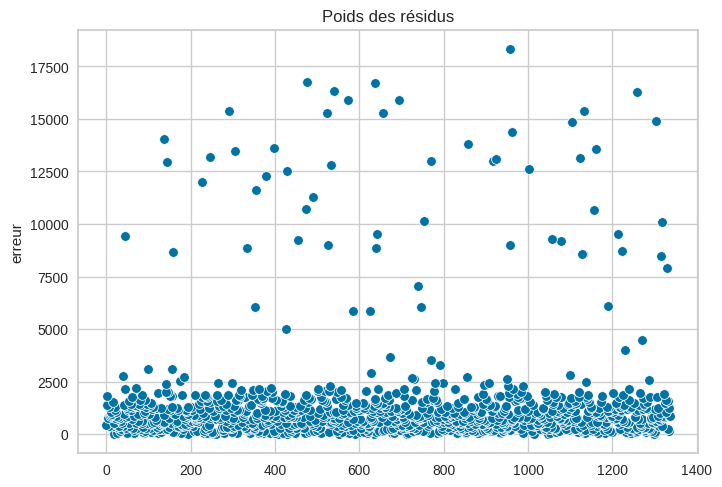

In [512]:
eN_pred = eN_model.best_estimator_.predict(X_train)
residual_elastic = (y_train - eN_pred).abs().sort_values()
sns.scatterplot( residual_elastic)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()


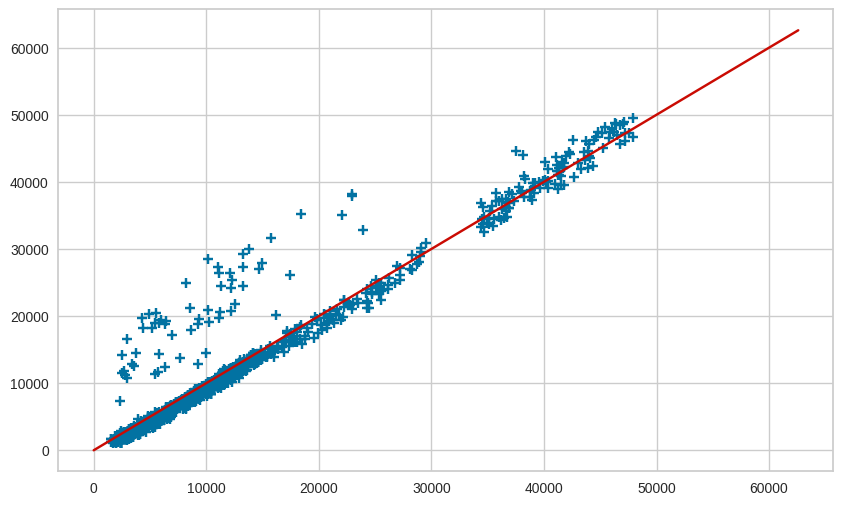

In [513]:
plt.subplots(figsize=(10, 6))
plt.scatter(eN_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()

In [514]:
np.sqrt(mean_squared_error(y_train,eN_pred))

2986.773142113972

#### B.1) Distance de COOK


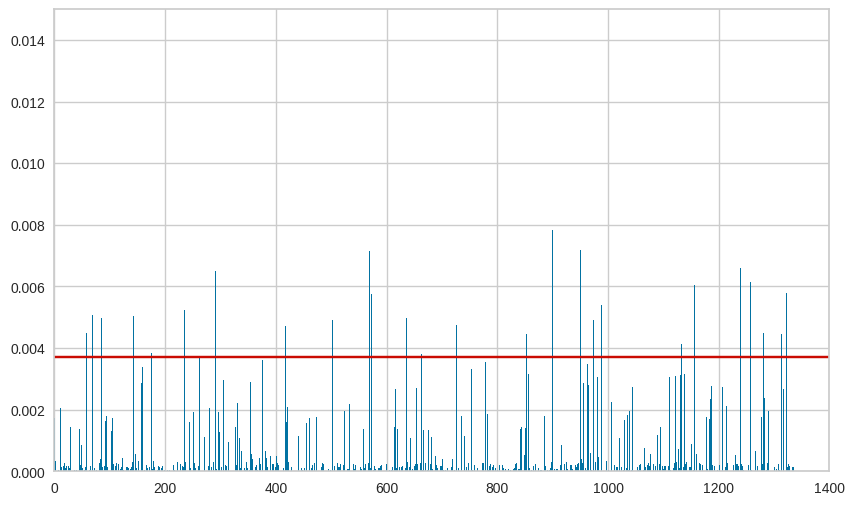

In [515]:
X_cook= preprocessor.transform(X_train)
X_cook_columns= preprocessor.get_feature_names_out()
newdf= pd.DataFrame(X_cook).set_index(y_train.index)
newdf.columns = X_cook_columns

X_cook=sm.add_constant(X_cook)
model_c = sm.OLS(y_train , X_cook).fit()
influence = model_c.get_influence().cooks_distance[0]
cooks_distance = influence

analyse=X_train.copy()
analyse['dcooks'] = influence
n= X_train.shape[0]
p = X_train.shape[1]
seuil_dcook = 4/(n-p)
plt.figure(figsize=(10,6))
plt.bar(analyse.index, analyse['dcooks'])
# plt.xticks(np.arange(0, 200, step=1))
# plt.xlabel('Observation')
# plt.ylabel('Leviers')
plt.plot([0, 1400], [seuil_dcook, seuil_dcook], color='r')
plt.axis([0,1400, 0, 0.015])
plt.show()


In [516]:
seuil_dcook

0.003703703703703704

In [517]:
residual_indice=analyse[analyse['dcooks']>seuil_dcook].index
residual_indice.size

X_train.drop(residual_indice, inplace=True)
y_train.drop(residual_indice, inplace=True)

In [518]:
y_pred = eN_model.best_estimator_.predict(X_train)
np.sqrt(mean_squared_error(y_train,y_pred))

2402.882951357735

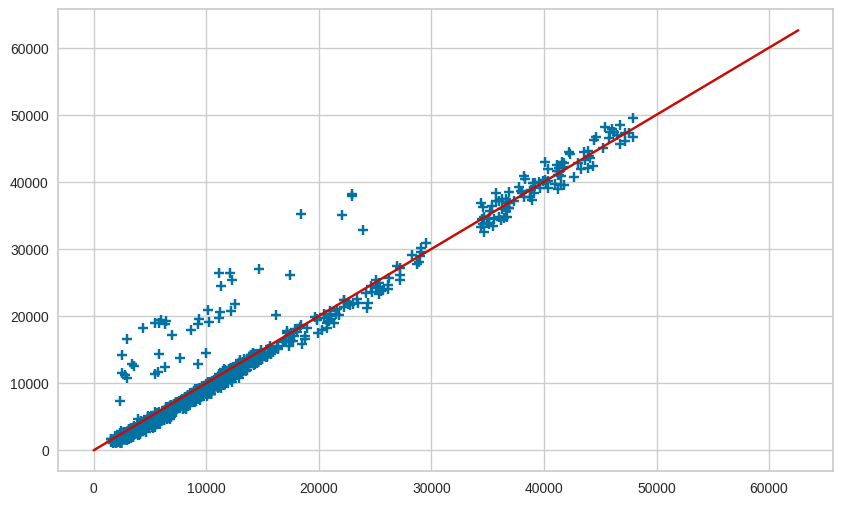

In [519]:
plt.subplots(figsize=(10, 6))
plt.scatter(y_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')
plt.show()

In [520]:
best_elastic = eN_model.best_estimator_
best_elastic.fit(X_train,y_train)
best_elastic.score(X_train,y_train)

0.9527069810028604

In [521]:
best_elastic.score(X_test,y_test)

0.8032444788991651

In [522]:
features_coeff = best_elastic[:-1].get_feature_names_out()
best_elastic = eN_model.best_estimator_
coeff = best_elastic[-1].coef_
df_coeff = pd.DataFrame([features_coeff,coeff], index=['features', 'coeff']).T.explode('coeff')


In [523]:
df_col = df_coeff[df_coeff['coeff']!=0]
df_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 3 to 119
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   features  21 non-null     object
 1   coeff     21 non-null     object
dtypes: object(2)
memory usage: 504.0+ bytes


# III) Exportation du modèle vers Streamlit

In [524]:
pickle_out = open("modellr.pkl", "wb") 
pickle.dump(lr_pipeline, pickle_out) 
pickle_out.close()
pickle_out4 = open("modelEN.pkl", "wb") 
pickle.dump(best_elastic, pickle_out4) 
pickle_out4.close()
